In [1]:
import numpy as np
from numba import cuda
from timeit import default_timer as timer
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# Using for loops

def transformImage(originalImage, transformMatrix):
    newImage = np.zeros(originalImage.shape)
    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            value = originalImage[i, j]
            oldCoords = np.array([i, j, 1])
            newCoords = transformMatrix.dot(oldCoords)
            u = int(newCoords[0])
            v = int(newCoords[1])
            if(u >= 0 and u < originalImage.shape[0] and v >= 0 and v < originalImage.shape[1]):
                newImage[u,v] = value
    return newImage


In [3]:
# Using CUDA

@cuda.jit
def transformImage_cuda(originalImage, newImage, transformMatrix, dimX, dimY):
    ix = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    iy = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    if ix < dimY and iy < dimY:
        value = originalImage[ix, iy]
        u = int(ix * transformMatrix[0,0] + iy * transformMatrix[0,1] + 1 * transformMatrix[0,2])
        v = int(ix * transformMatrix[1,0] + iy * transformMatrix[1,1] + 1 * transformMatrix[1,2])
        if u >= 0 and u < dimX and v >= 0 and v < dimY:
            newImage[u,v] = value

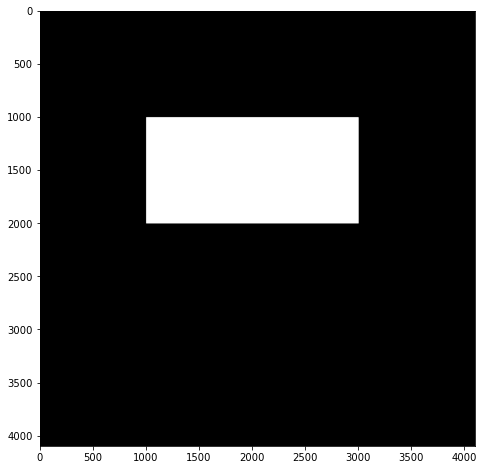

In [4]:
n = 4096
img = np.zeros((n, n))
img[1000:3000,1000:2000] = 1
fig, axs = plt.subplots(1,  figsize=(8,8))
axs.imshow(img.T, cmap="Greys_r")

In [5]:
# Affine transformation matrix

# Translation example
transformMatrix = np.array([[1, 0, 1000],
                            [0, 1, 0],
                            [0, 0, 1]])

## Rotation example
# angle = np.radians(60.0)
# transformMatrix = np.array([[np.cos(angle), -np.sin(angle), 1000],
#                             [np.sin(angle), np.cos(angle), 0],
#                             [0, 0, 1]])

Execution time: 51.253946000000724


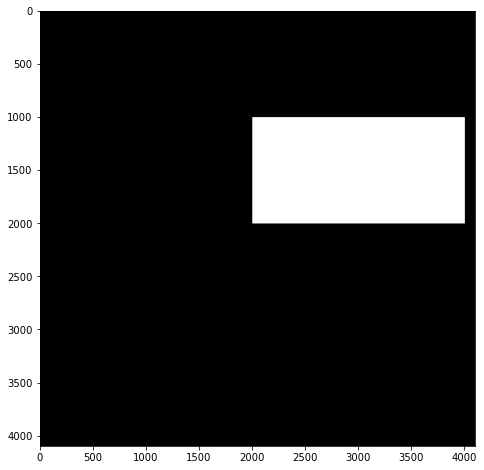

In [6]:
start = timer()
newImg = transformImage(img, transformMatrix)
print("Execution time:", timer() - start)

fig, axs = plt.subplots(1,  figsize=(8,8))
axs.imshow(newImg.T, cmap="Greys_r")

Transfer to device: 0.3355461999999534
Computation: 0.2621370000015304
Transfer to host: 0.030798399999184767
Total time: 0.6284816000006685


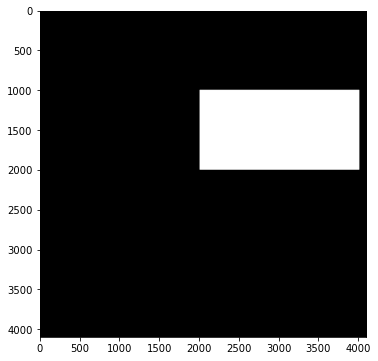

In [7]:

t = np.zeros(3)

blockdim = (16, 16)
griddim = (img.shape[0] // blockdim[0] + 1, img.shape[1] // blockdim[1] + 1)
start = timer()
d_orig = cuda.to_device(img)
d_transform = cuda.to_device(transformMatrix)
newImg_cuda = np.zeros(img.shape)
d_newImg  = cuda.to_device(newImg_cuda)
t[0] = timer() - start
transformImage_cuda[griddim, blockdim](d_orig, d_newImg, d_transform, img.shape[0], img.shape[1])
t[1] = timer() - start - t[0]
d_newImg.to_host()
t[2] = timer() - start - t[0] - t[1]

print("Transfer to device:", t[0])
print("Computation:", t[1])
print("Transfer to host:", t[2])
print("Total time:", np.sum(t))

fig, axs = plt.subplots(1,  figsize=(6,6))
axs.imshow(newImg_cuda.T, cmap="Greys_r")